# Read the data

In [2]:
import pandas as pd
import numpy as np

train_path = "./data/FM/fashion-mnist_train.csv"
test_path  = "./data/FM/fashion-mnist_test.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("train shape:", train_df.shape)
print("test shape :", test_df.shape)
train_df.head()


train shape: (60000, 785)
test shape : (10000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# 假设第 1 列叫 "label" 或在第 0 列
y_train = train_df.iloc[:, 0].values
X_train = train_df.iloc[:, 1:].values.astype("float32") / 255.0  # 像素缩放到 0~1

y_test = test_df.iloc[:, 0].values
X_test = test_df.iloc[:, 1:].values.astype("float32") / 255.0

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape, "y_test :", y_test.shape)



X_train: (60000, 784) y_train: (60000,)
X_test : (10000, 784) y_test : (10000,)


In [4]:
from sklearn.model_selection import train_test_split

# 从训练集中取 10% 做 calibration
X_model, X_cal, y_model, y_cal = train_test_split(
    X_train, y_train, 
    test_size=0.1, 
    random_state=0,
    stratify=y_train
)




In [25]:

from sklearn.preprocessing import StandardScaler
import numpy as np

# 假设 X_* 原始 shape 为 (N, 784)，对应 28x28 灰度图
scaler = StandardScaler()
X_model_scaled = scaler.fit_transform(X_model)
X_cal_scaled   = scaler.transform(X_cal)
X_test_scaled  = scaler.transform(X_test)


# ==========================================================
# 1. 训练模型（IMPORTANT：只用 X_model，而不是全部训练集）
# ==========================================================
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(
    max_iter=300
)
log_clf.fit(X_model, y_model)
# log_clf.fit(X_model_scaled, y_model)



# ---------------- XGBoost ----------------
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    n_estimators=150,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    n_jobs=-1
)
xgb_clf.fit(X_model, y_model)   



/opt/homebrew/Caskroom/miniconda/base/envs/course_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


naive baysen

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()
nb_clf.fit(X_model, y_model)


,priors,None
,var_smoothing,1e-09


In [36]:
# ==========================================================
# 2. 计算 calibration softmax（Conformal 的 calibration data）
# ==========================================================
log_cal_smx = log_clf.predict_proba(X_cal)
# log_cal_smx = log_clf.predict_proba(X_cal_scaled)

xgb_cal_smx = xgb_clf.predict_proba(X_cal)
nb_cal_smx  = nb_clf.predict_proba(X_cal)   # 如果 nb 用的是 X_model_scaled，就改成 X_cal_scaled


cal_labels = y_cal


# ==========================================================
# 3. 计算 test softmax（Conformal 的 validation/test data）
# ==========================================================
log_val_smx = log_clf.predict_proba(X_test)
# log_val_smx = log_clf.predict_proba(X_test_scaled)

xgb_val_smx = xgb_clf.predict_proba(X_test)
nb_val_smx  = nb_clf.predict_proba(X_test)  # 同理，可改成 X_test_scaled

val_labels = y_test

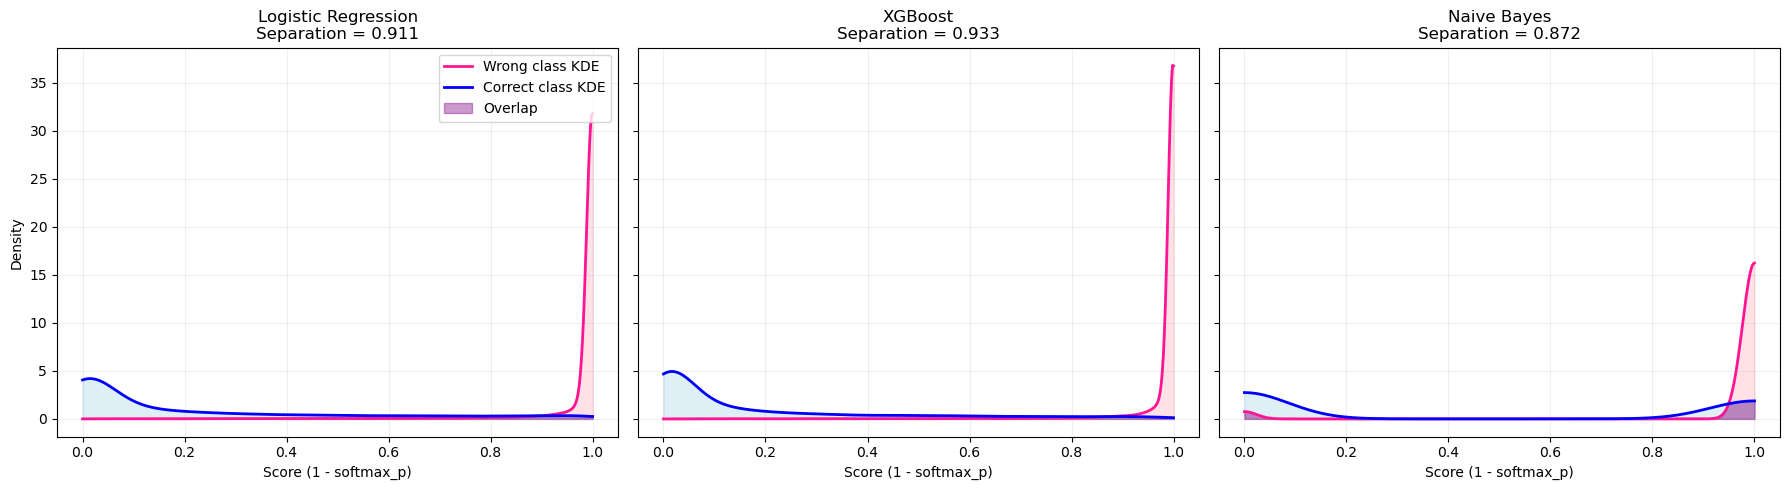

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# ==========================================================
# 获取 模型在 calibration set 的 score
# ==========================================================
def get_scores(proba, labels):
    n, K = proba.shape
    correct_scores = 1 - proba[np.arange(n), labels]

    wrong_scores = []
    for i in range(n):
        for k in range(K):
            if k != labels[i]:
                wrong_scores.append(1 - proba[i, k])
    wrong_scores = np.array(wrong_scores)
    return correct_scores, wrong_scores


# ==========================================================
# 计算分离度（Separation Degree）
# ==========================================================
def separation_index(correct, wrong, xs=None):
    """
    separation index 越大越好（0=完全重叠, 1=完美分离）
    定义为：
        1 - overlap_area
    overlap_area = 两个 KDE 曲线的最小值积分
    """
    if xs is None:
        xs = np.linspace(0, 1, 500)
    
    kde_c = gaussian_kde(correct)
    kde_w = gaussian_kde(wrong)

    pc = kde_c(xs)
    pw = kde_w(xs)

    overlap = np.trapz(np.minimum(pc, pw), xs)
    sep = 1 - overlap
    
    return sep, xs, pc, pw


# ==========================================================
# 依次对三种模型计算分离度并画图
# 需要你事先已经有：
#   log_cal_smx, xgb_cal_smx, nb_cal_smx, cal_labels
# ==========================================================
model_probs = [
    ("Logistic Regression", log_cal_smx),
    ("XGBoost", xgb_cal_smx),
    ("Naive Bayes", nb_cal_smx),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (name, proba) in zip(axes, model_probs):
    correct, wrong = get_scores(proba, cal_labels)
    sep_value, xs, pc, pw = separation_index(correct, wrong)

    # wrong class curve
    ax.plot(xs, pw, color="deeppink", linewidth=2, label="Wrong class KDE")
    ax.fill_between(xs, pw, color="lightpink", alpha=0.4)

    # correct class curve
    ax.plot(xs, pc, color="blue", linewidth=2, label="Correct class KDE")
    ax.fill_between(xs, pc, color="lightblue", alpha=0.4)

    # overlap region
    ax.fill_between(xs, np.minimum(pc, pw), color="purple", alpha=0.4, label="Overlap")

    ax.set_title(f"{name}\nSeparation = {sep_value:.3f}")
    ax.set_xlabel("Score (1 - softmax_p)")
    ax.grid(alpha=0.2)

axes[0].set_ylabel("Density")
axes[0].legend(loc="upper right")
plt.tight_layout()
plt.show()


In [39]:
# ==========================================================
# 4. 检查模型准确率（Accuracy）
# ==========================================================
from sklearn.metrics import accuracy_score

# Logistic Regression 预测（注意使用 scaled）
log_pred = log_clf.predict(X_test_scaled)
log_acc = accuracy_score(y_test, log_pred)

nb_pred = nb_clf.predict(X_test)
nb_acc = accuracy_score(y_test, nb_pred)

# XGBoost 预测（原始特征）
xgb_pred = xgb_clf.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)



print("=======================================")
print(f"Logistic Regression Accuracy: {log_acc:.4f}")
print(f"XGBoost Accuracy            : {xgb_acc:.4f}")
print(f"Naive Bayes Accuracy        : {nb_acc:.4f}")
print("=======================================")




Logistic Regression Accuracy: 0.7470
XGBoost Accuracy            : 0.8909
Naive Bayes Accuracy        : 0.5927


In [29]:
import numpy as np

def split_conformal_prediction(cal_smx, cal_labels, val_smx, val_labels, alpha=0.05):
    """
    Inputs:
        cal_smx   : calibration softmax (n_cal, K)
        cal_labels: calibration labels   (n_cal,)
        val_smx   : test softmax         (n_test, K)
        val_labels: test labels          (n_test,)
        alpha     : miscoverage level (e.g., 0.1 for 90% coverage)
    Returns:
        coverage    : CP coverage on test set
        avg_set_size: average size of prediction sets
        pred_sets   : list of prediction set for each test sample
        q_hat       : conformal threshold
    """
    
    n_cal = cal_smx.shape[0]
    
    # 1. calibration scores
    cal_true_probs = cal_smx[np.arange(n_cal), cal_labels]
    cal_scores = 1 - cal_true_probs

    # 2. conformal quantile
    q_level = np.ceil((n_cal + 1) * (1 - alpha)) / n_cal
    q_hat = np.quantile(cal_scores, q_level, method="higher")

    # 3. prediction sets on test
    pred_sets = []
    for i in range(val_smx.shape[0]):
        scores_k = 1 - val_smx[i]
        S = np.where(scores_k <= q_hat)[0]
        pred_sets.append(S)

    # 4. coverage
    covered = [val_labels[i] in pred_sets[i] for i in range(len(val_labels))]
    coverage = np.mean(covered)

    # 5. average set size
    avg_set_size = np.mean([len(s) for s in pred_sets])

    return coverage, avg_set_size, pred_sets, q_hat


In [60]:
alpha_set = 0.05

log_cov, log_size, log_sets, log_q = split_conformal_prediction(
    log_cal_smx, cal_labels, log_val_smx, val_labels, alpha=alpha_set
)

print("Logistic CP coverage:", log_cov)
print("Logistic CP avg set size:", log_size)

xgb_cov, xgb_size, xgb_sets, xgb_q = split_conformal_prediction(
    xgb_cal_smx, cal_labels, xgb_val_smx, val_labels, alpha=alpha_set
)

print("XGBoost CP coverage:", xgb_cov)
print("XGBoost CP avg set size:", xgb_size)

nb_cov, nb_size, nb_sets, nb_q = split_conformal_prediction(
    nb_cal_smx, cal_labels, nb_val_smx, val_labels, alpha=alpha_set
)   
print("Naive Bayes CP coverage:", nb_cov)
print("Naive Bayes CP avg set size:", nb_size)

Logistic CP coverage: 0.9477
Logistic CP avg set size: 1.3937
XGBoost CP coverage: 0.9506
XGBoost CP avg set size: 1.198
Naive Bayes CP coverage: 1.0
Naive Bayes CP avg set size: 10.0


In [61]:
idx = 5  # 想查看的样本编号

print("===== Logistic Regression =====")
print("True label:", val_labels[idx])

# 模型本来的预测
log_pred = log_clf.predict(X_test_scaled)[idx]
print("Model predicted label:", log_pred)

# Conformal Prediction set
print("CP Prediction set:", log_sets[idx])
print("Set size:", len(log_sets[idx]))


print("\n===== XGBoost =====")
print("True label:", val_labels[idx])

# 模型本来的预测
xgb_pred = xgb_clf.predict(X_test)[idx]
print("Model predicted label:", xgb_pred)

# Conformal Prediction set
print("CP Prediction set:", xgb_sets[idx])
print("Set size:", len(xgb_sets[idx]))

print("\n===== Naive Bayes =====")
print("True label:", val_labels[idx])
# 模型本来的预测
nb_pred = nb_clf.predict(X_test)[idx]
print("Model predicted label:", nb_pred)
# Conformal Prediction set
print("CP Prediction set:", nb_sets[idx])
print("Set size:", len(nb_sets[idx]))


===== Logistic Regression =====
True label: 2
Model predicted label: 3
CP Prediction set: [0 2 6]
Set size: 3

===== XGBoost =====
True label: 2
Model predicted label: 6
CP Prediction set: [0 6]
Set size: 2

===== Naive Bayes =====
True label: 2
Model predicted label: 6
CP Prediction set: [0 1 2 3 4 5 6 7 8 9]
Set size: 10
